# Illustration of the DeepBSDE Solver

## General Information
In this Jupyter notebook we illustrate the DeepBSDE solver as introduced in

- W. E, J. Han and A. Jentzen. *Deep learning-based numerical methods for high-dimensional parabolic partial differential equations and backward stochastic differential equations*. Communications in Mathematics and Statistics, 5, 349–380 (2017), see [published version](https://doi.org/10.1007/s40304-017-0117-6) or [arXiv preprint](https://arxiv.org/abs/1706.04702)
- J. Han, A. Jentzen and W. E. *Solving high-dimensional partial differential equations using deep learning*. PNAS August 21, 2018 115 (34) 8505-8510, see [published version](https://doi.org/10.1073/pnas.1718942115) or [arXiv preprint](https://arxiv.org/abs/1707.02568).

The code in this notebook is partially based on the [Deep BSDE GitHub repository](https://github.com/frankhan91/DeepBSDE) by Jiequn Han.
For best results we recommend running this notebook with GPU acceleration, e.g., from within Google Colab by simply clicking the button below:


<br>



<a href="https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/DeepBSDE_Solver.ipynb" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Introduction

In this section we extend the methodology of the [Feynman-Kac solver (GitHub)](https://github.com/janblechschmidt/PDEsByNNs/blob/main/Feynman-Kac_Solver.ipynb) to solving *semilinear* PDEs in the form of the final value problem

$$
\begin{aligned}
   \partial_t u(t,x) 
   + \frac{1}{2} \sigma \sigma^T(t,x) : \nabla^2 u(t,x) 
   + \mu(t,x) \cdot \nabla u(t,x) 
   + f(t,x,u(t,x),\sigma^T(t,x) \nabla u(t,x)) 
   &= 0, 
   	\quad &&(t,x) \in [0,T) \times \mathbb R^d,\\
   u(T,x) &= g(x), \quad &&x \in  \mathbb R^d,
\end{aligned}
$$

with drift $\mu\colon[0,T] \times \mathbb R^d \to \mathbb R^d$, diffusion $\sigma\colon[0,T] \times\mathbb R^d \to \mathbb R^{d \times d}$ and final data $g\colon\mathbb R^d \to \mathbb R$ as before.
The function $f\colon [0,T] \times \mathbb R^d \times \mathbb R \times \mathbb R^d \to \mathbb R$ containing lower order terms can depend in a general way on the independent variables $t,x$ as well as on the solution $u(t,x)$  and its transformed gradient $(\sigma^T\nabla) u(t,x)$.
Here, $\nabla u(t,x)$ and $\nabla^2 u(t,x)$ denote the gradient and Hessian of the function $u$, resp., the colon sign "$:$" denotes the Frobenius inner product, i.e., $A:B = \sum_{i,j=1}^d a_{ij} \, b_{ij}$.
The non-divergence form of the leading-order term as well as the specific dependence on $\sigma^T\nabla u$ again result from the connection between PDEs and stochastic processes.
As we will see below, the presence of these dependencies requires extending the numerical solution method to include additional approximating stochastic processes for $\nabla u$.

Semilinear PDEs of the form above arise 
in physical models such as, e.g., the Allen-Cahn, Burgers or reaction-diffusion equations; 
in finance, e.g., for pricing derivatives with default risk;
and in stochastic control problems.
The method discussed below is an extension to that presented in [Feynman-Kac solver (GitHub)](https://github.com/janblechschmidt/PDEsByNNs/blob/main/Feynman-Kac_Solver.ipynb) in that it is also based on the PDE-SDE connection, but in this case it is the correspondence of nonlinear PDEs with *backward stochastic differential equations (BSDEs)*.
In the linear case discussed in [Feynman-Kac solver (GitHub)](https://github.com/janblechschmidt/PDEsByNNs/blob/main/Feynman-Kac_Solver.ipynb) the approximation of the solution $u$ at time $t=0$ is based on a neural network approximation of the mapping $u(0,\cdot):\mathcal D \to \mathbb R$, the Feynman-Kac representation $u(0,x) = \mathbb E[g(X_T) \, | \, X_0 = x]$ for $x \in \mathcal D$ and generating a large number of 
sample paths of the stochastic process $\{X_t\}_{t \in [0,T]}$ governed by an associated SDE to approximate the conditional expectation and train the model.
Using the theory of BSDEs, it is possible to treat also nonlinearities of the type contained in the semilinear PDE.

The specific method presented here was proposed in [[E, Han, Jentzen (2017)](https://doi.org/10.1007/s40304-017-0117-6)] and [[Han, Jentzen, E (2018)](https://doi.org/10.1073/pnas.1718942115).
Again, the focus lies on solving high-dimensional problems and overcoming one source of the curse of dimensionality: a high-dimensional state space (large $d$).

---

The implementation below addresses the problem of evaluating the PDE solution at $t=0$ in a fixed spatial point $x$.
However, the code can be modified to obtain the solution of the PDE at $t=0$ in a domain of interest $\mathcal{D} \subset \mathbb{R}^d$, as described in [Feynman-Kac solver (GitHub)](https://github.com/janblechschmidt/PDEsByNNs/blob/main/Feynman-Kac_Solver.ipynb).

## Theoretical background
The method is based on the connection of nonlinear PDEs and backward stochastic differential equations (BSDEs).
Given a filtered probability space $(\Omega, \mathcal{F}, \mathbb{P}; \mathbb{F})$ equipped with the filtration $\{\mathcal{F}_t\}_{t \in [0,T]}$ induced by a Brownian motion $\{W_t\}_{t \in [0,T]}$,
the stochastic process $\{X_t\}_{t \in [0,T]}$ describes the evolution of the state variable for all $t \in [0,T]$ via the (forward) SDE

$$
X_t = x + \int_0^t \mu(s,X_s) \, ds + \int_0^t \sigma(s,X_s) \, dW_s,
$$

which directly implies $X_0 = x$.
The backward SDE associated with this process is

$$
Y_t = g(X_T) + \int_t^T f(s, X_s, Y_s, Z_s) \, ds - \int_t^T Z_s \cdot dW_s,
$$

which in particular implies $Y_T = g(X_T)$.

Under suitable regularity assumptions on the coefficients $\mu, \sigma, f$ and $g$, the link to the nonlinear PDE is given by the fact that for all $t \in [0,T]$ it holds $\mathbb{P}$-a.s. that

$$
Y_t = u(t,X_t) \quad \text{and} \quad Z_t = (\sigma^T \nabla u) (t, X_t).
$$

Thus, the solution $u(0, x)$ can be obtained through the knowledge of $Y_0 = u(0, X_0) = u(0, x)$.

## Semi-discretization in time
We discretize the time interval $[0,T]$ into $N$ equidistant subintervals $0=t_0 < t_1 < \ldots < t_N = T$ with constant step size $\Delta t = T/N$.
To approximate $\{X_t\}_{t \in [0,T]}$, we employ the Euler-Maruyama scheme for the forward SDE which yields

$$
\tilde X_{{n+1}} = \tilde X_{n}
+ \mu(t_n, \tilde X_{n}) \, (t_{n+1} - t_n)
+ \sigma(t_n, \tilde X_{n}) \, (W_{t_{n+1}} - W_{t_n}),
$$

where $\tilde X_n \approx X_{t_n}$.
Analogously, we obtain a discretization of the backward SDE as

$$
\tilde Y_{{n+1}} = \tilde Y_{n} 
- f(t_n, \tilde X_{n}, \tilde Y_{n}, \tilde Z_{n}) \, (t_{n+1} - t_n)
+ \tilde Z_{n} \cdot ( W_{t_{n+1}} - W_{t_n}),
$$

where $\tilde Y_n \approx Y_{t_n}$ and $\tilde Z_n \approx Z_{t_n}$.
We emphasize again that we are interested in the value $\tilde Y_{0} \approx Y_0 = u(0, x)$.
Note that the increment of a Brownian motion $( W_{t_{n+1}} - W_{t_n}) \sim \mathsf{N}(0,(t_{n+1} - t_n) I_{d\times d})$ is normally distributed.

## Implementation Walkthrough

### 1. Import necessary packages
This code runs with TensorFlow versions `2.4.1`, although it should be compatible with versions `>2.3.0`.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from time import time

# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))

TensorFlow version used: 2.10.0


### 2. Simulation of $\{\tilde X_{i}\}_{i=0, \ldots, N}$ and $\{W_{t_i}\}_{i=0, \ldots, N}$

Without specifying the example now we start by setting some quantities that are important for the discretization of the processes.

In [2]:
# Final time
T = 1.

# Spatial dimensions
dim = 100

# Number of equidistant intervals in time
N = 20

# Derive time step size and t_space
dt = T/N
t_space = np.linspace(0, T, N + 1)

# Point-of-interest at t=0
x = np.zeros(dim)

# Diffusive term is assumed to be constant
sigma = np.sqrt(2)

Next, we define a function to draw multiple sample paths of $\{\tilde X_{i}\}_{i=0, \ldots, N}$ and the corresponding increments of the Brownian motions $\{W_{t_i}\}_{i=0, \ldots, N}$ according to

$$
\tilde X_{{n+1}} = \tilde X_{n}
+ \mu(t_n, \tilde X_{n}) \, (t_{n+1} - t_n)
+ \sigma(t_n, \tilde X_{n}) \, ( W_{t_{n+1}} - W_{t_n}), \qquad \tilde X_0 = x,
$$

for the particular case $\mu(t,X_t) \equiv 0$ and $\sigma(t,X_t) \equiv \sigma I_{d \times d}$.

In [3]:
def draw_X_and_dW(num_sample, x):
    """ Function to draw num_sample many paths of the stochastic process X
    and the corresponding increments of simulated Brownian motions dW. """
    
    dim = x.shape[0]
    
    # Draw all increments of W at once
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(num_sample, dim, N)).astype(DTYPE)

    # Initialize the array X
    X = np.zeros((num_sample, dim, N+1), dtype=DTYPE)
    
    # Set starting point to x for each draw
    X[:, :, 0] = np.ones((num_sample, dim)) * x
    
    for i in range(N):
        # This corresponds to the Euler-Maruyama Scheme
        X[:, :, i+1] = X[:, :, i] + sigma * dW[:, :, i]

    # Return simulated paths as well as increments of Brownian motion
    return X, dW

Finally, we may test the function and draw 10 samples of the process $\{\tilde X_{i}\}_{i=0,\ldots,N}$.

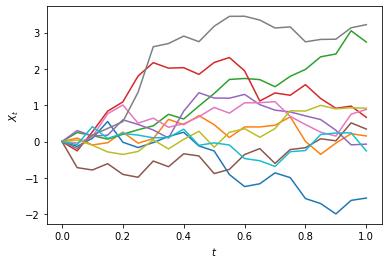

In [4]:
num_sample=10

# Draw 10 sample paths
X,dW = draw_X_and_dW(num_sample, np.zeros(1))

# Plot these paths
fig,ax = plt.subplots(1)
for i in range(num_sample):
    ax.plot(t_space,X[i,0,:])
ax.set_xlabel('$t$')
ax.set_ylabel('$X_t$');

### 3. Simulation of $\{\tilde Y_{i}\}_{i=0, \ldots, N}$
A recapulation of the update formula of the value process $Y$, i.e.

$$
\tilde Y_{{n+1}} = \tilde Y_{n} 
- f(t_n, \tilde X_{n}, \tilde Y_{n}, \tilde Z_{n}) \, (t_{n+1} - t_n)
+ \tilde Z_{n} \cdot (W_{t_{n+1}} - W_{t_n}), \qquad \tilde Y_N = g(\tilde X_N),
$$

indicates that there are multiple unknowns present in this equation, namely

  - $\tilde Y_{0}$, an approximation of $u(0, x)$ as well as
  - $\tilde Z_{i}$, the approximations of $\sigma^T(t_i, \tilde X_{i}) \nabla u(t_i, \tilde X_{i})$ for $i = 0,\ldots,N-1$.

The unknowns $\tilde Y_{0} \approx u(0, x) \in \mathbb R$ and $\tilde Z_{0} \approx (\sigma^T \nabla u)(0, x) \in \mathbb R^d$ are treated as individual network parameters (we only need both of them in the particular point $(0,x)$) which are learned during training.

To approximate the remaining unknowns $\tilde Z_{i}$ we employ neural networks which realize the mappings $x \mapsto \sigma^T(t_i, x) \nabla u(t_i, x)$ for $i=1,\ldots,N$.

These networks have the following structure:

    Input -> BN -> (Dense -> BN -> ReLU) -> (Dense -> BN -> ReLU) -> Dense -> BN -> Output
    
Here, `BN` denotes Batch Normalization, `Dense` a fully connected layer **without** bias term and activation, and `ReLU` the componentwise application of the  ReLU activation function $\mathrm{relu}(x) = \max \{0,x\}$.
All additional parameters except the initialization of `u0` and `gradu0` are chosen according to the values given in the [DeepBSDE GitHub repository](https://github.com/frankhan91/DeepBSDE) by Jiequn Han.

We define the complete network as one class derived from `tf.keras.model`.
This has several advantages, which will become clear later.

In [5]:
class BSDEModel(tf.keras.Model):
    def __init__(self, **kwargs):
        
        # Call initializer of tf.keras.Model
        super().__init__(**kwargs)
        
        # Initialize the value u(0, x) randomly
        u0 = np.random.uniform(.1, .3, size=(1)).astype(DTYPE)
        self.u0 = tf.Variable(u0)
        
        # Initialize the gradient nabla u(0, x) randomly
        gradu0 = np.random.uniform(-1e-1, 1e-1, size=(1, dim)).astype(DTYPE)
        self.gradu0 = tf.Variable(gradu0)
        
        # Create template of dense layer without bias and activation
        _dense = lambda dim: tf.keras.layers.Dense(
            units=dim,
            activation=None,
            use_bias=False)
        
        # Create template of batch normalization layer
        _bn = lambda : tf.keras.layers.BatchNormalization(
            momentum=.99,
            epsilon=1e-6,
            beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
            gamma_initializer=tf.random_uniform_initializer(0.1, 0.5))
        
        
        # Initialize a list of networks approximating the gradient of u(t, x) at t_i
        self.gradui = []
        
        # Loop over number of time steps
        for _ in range(N - 1):
            
            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())
            
            # Two hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(2):
                this_grad.add(_dense(dim+10))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.ReLU())
                
            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.gradui.append(this_grad)

Next, we define a function to draw multiple realizations of $\tilde Y_{N} \approx u(T, X_T)$ by sweeping through the network.
The intermediate values $\{\tilde Y_{i}\}_{i=0,\ldots,N-1}$ are not stored.

In [6]:
def simulate_Y(inp, model, fun_f):
    """ This function performs the forward sweep through the network.
    Inputs:
        inp - (X, dW)
        model - model of neural network, contains
            - u0  - variable approximating u(0, x)
            - gradu0 - variable approximating nabla u(0, x)
            - gradui - list of NNs approximating the mapping: x -> nabla u(t_i, x)
        fun_f - function handle for cost function f
    """
    
    X, dW = inp
    num_sample = X.shape[0]


    e_num_sample = tf.ones(shape=[num_sample, 1], dtype=DTYPE)

    # Value approximation at t0
    y = e_num_sample * model.u0

    # Gradient approximation at t0
    z = e_num_sample * model.gradu0

    for i in range(N-1):
        t = t_space[i]
        
        # Determine terms in right-hand side of Y-update at t_i
        eta1 = - fun_f(t, X[:, :, i], y, z) * dt
        eta2 = tf.reduce_sum(z * dW[:, :, i], axis=1, keepdims=True)
        
        # Compute new value approximations at t_{i+1}
        y = y + eta1 + eta2

        # Obtain gradient approximations at t_{i+1}
        # Scaling the variable z by 1/dim improves the convergence properties
        # and has been used in the original code https://github.com/frankhan91/DeepBSDE
        # z still approximates \sigma^T \nabla u, but the network learns to represent
        # a scaled version.
        z = model.gradui[i](X[:, :, i + 1]) / dim

        
    # Final step
    eta1 = - fun_f(t_space[N-1], X[:, :, N-1], y, z) * dt
    eta2 = tf.reduce_sum(z * dW[:, :, N-1], axis=1, keepdims=True)
    y = y + eta1 + eta2

    return y

Through the application of this function, we may generate for each approximate state path $\{\tilde X_{i}\}_{i=0,\ldots,N}$ with corresponding Brownian motion $\{ W_{t_i}\}_{i=0,\ldots,N}$ one realization of $\tilde Y_N$ given our unknown network parameters

$$
\theta = \left( \theta_{u_0}, \theta_{\nabla u_0}, \theta_{\nabla u_1}, \ldots \theta_{\nabla u_{N-1}} \right).
$$

### 4. Evaluation of loss function

In the next step, we define the loss function, i.e., the function to be minimized.
Since $\tilde Y_N$ approximates $u(T, X_T) = g(X_T)$ we minimize the mean squared error (MSE) between $\tilde Y_N$ and $g(\tilde X_N)$.

In [7]:
def loss_fn(inp, model, fun_f, fun_g):
    """ This function computes the mean-squarred error of the difference of Y_T and g(X_T)
    Inputs:
        inp - (X, dW)
        model - model of neural network containing u0, gradu0, gradui
        fun_f - function handle for cost function f
        fun_g - function handle for terminal condition g
    """
    X, _ = inp
    
    # Forward pass to compute value estimates
    y_pred = simulate_Y(inp, model, fun_f)
        
    # Final time condition, i.e., evaluate g(X_T)
    y = fun_g(X[:, :, -1])
    
    # Compute mean squared error
    y_diff = y-y_pred    
    loss = tf.reduce_mean(tf.square(y_diff))
    
    return loss

### 5. Computation of the gradient w.r.t. the network parameters $\theta$

The next step uses the automatic differentiation functionality of TensorFlow to compute the gradient of the loss function with respect to the unknowns $\theta$, called `trainable_variables` in TensorFlow.

In [8]:
@tf.function
def compute_grad(inp, model, fun_f, fun_g):
    """ This function computes the gradient of the loss function w.r.t.
    the trainable variables theta.
    Inputs:
        inp - (X, dW)
        model - model of neural network containing u0, gradu0, gradui
        fun_f - function handle for cost function f
        fun_g - function handle for terminal condition g
    """
    
    with tf.GradientTape() as tape:
        loss = loss_fn(inp, model, fun_f, fun_g)
        
    grad = tape.gradient(loss, model.trainable_variables)
    
    return loss, grad

## Solution of a linear-quadratic Gaussian control problem

The next code block defines the coefficient functions $f$ and $g$ for the linear-quadratic Gaussian control problem for a stochastic process
$\{X_t\}_{t \in [0,T]}$ governed by the SDE

$$
X_t = x + \int_0^t 2 m_t \, \mathrm{d}t + \int_0^t \sqrt{2}\, I_{d \times d} \, \mathrm{d} W_t.
$$

with a control process $\{m_t\}_{t \in [0,T]}$ with values in $\mathbb{R}^d$.
The solution of the control problem is characterized by the value function, i.e., the function $u ∶ [0, T ] \times \mathbb R^d \to \mathbb R$ that gives the minimal expected sum of accumulated running cost and final cost over all
admissible control processes from time $t=0$ onward starting at $x$

$$
u(0,x) = \min_{m_t} \mathbb{E} \left[ \int_0^T \|m_t\|^2 \mathrm{d}t + g(X_T)\;  \big|  \; X_0 = x \right],
$$

The function $g:\mathbb{R}^d \to \mathbb{R}$ describes the terminal cost when the process ends at $X_T \in \mathbb R^d$.
The Hamilton-Jacobi-Bellman equation associated with the stochastic
control problem is given by the nonlinear PDE

$$
\partial_t u(t,x) + \Delta u(t,x) + \min_m \{ 2 \, m \cdot \nabla u(t,x) + \|m\|^2\} = 0, \qquad u(T,x) = g(x).
$$

Note that this equation is purely deterministic.
As one can easily see, the minimum is attained at $m = - \nabla u$, which yields the semilinear PDE

$$
\partial_t u(t,x) + \Delta u(t,x) -  \|\nabla u(t,x)\|^2 = 0,
$$

which will now be solved using deep neural networks.

---

Remember, the drift term $\mu$ has been set to zero in the `draw_X_and_dW` function and the diffusion has been set to $\sigma = \sqrt{2} I_{d \times d}$, which reduces the term $1/2 \, \sigma \sigma^T(t,x):\nabla^2 u(t,x)$ to $\Delta u(t,x)$.

**Note**: The optimizer which performs the gradient descent step and in particular its step size (aka learning rate) have to be chosen carefully.
The speed of convergence may depend strongly on the initialization of the unknown variables $\theta$ as well as the the optimizer settings, e.g., a learning rate that is too high may yield a divergent sequence while values which are too low may result in slow convergence.

In [9]:
# Define cost function f, remember that z approximates \sigma^T \nabla u
def fun_f(t, x, y, z):
    return - tf.reduce_sum(tf.square(z), axis=1, keepdims=True) / (sigma**2)

# Set terminal value function g
def fun_g(x):
    return tf.math.log( (1+tf.reduce_sum(tf.square(x), axis=1, keepdims=True)) / 2)

# Set learning rate
lr = 1e-2
# Choose optimizer for gradient descent step
optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8)

# Initialize neural network architecture
model = BSDEModel()
y_star = 4.59016

# Initialize list containing history of losses
history = []

Next, we train the model for multiple epochs using batches of size 64.

In [14]:
t0 = time()

num_epochs = 1000  # 40000

# Initialize header of output
print('  Iter        Loss        y   L1_rel    L1_abs   |   Time  Stepsize')

for i in range(num_epochs):
    
    # Each epoch we draw a batch of 64 random paths
    X, dW = draw_X_and_dW(64, x)

    # Compute the loss as well as the gradient
    loss, grad = compute_grad((X, dW), model, fun_f, fun_g)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    
    # Get current Y_0 \approx u(0,x)
    y = model.u0.numpy()[0]

    currtime = time() - t0
    l1abs = np.abs(y - y_star)
    l1rel = l1abs / y_star
    
    hentry = (i, loss.numpy(), y, l1rel, l1abs, currtime, lr)
    history.append(hentry)
    if i%10 == 0:
        print('{:5d} {:12.4f} {:8.4f} {:8.4f}  {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))

  Iter        Loss        y   L1_rel    L1_abs   |   Time  Stepsize
    0       8.5134   1.0220   0.7774    3.5682   |    0.1  1.00e-02
   10       5.6105   1.0587   0.7693    3.5314   |    0.9  1.00e-02
   20       5.2987   1.0966   0.7611    3.4935   |    1.7  1.00e-02
   30       6.5376   1.1355   0.7526    3.4547   |    2.4  1.00e-02
   40       7.1658   1.1751   0.7440    3.4151   |    3.2  1.00e-02
   50       6.5768   1.2215   0.7339    3.3687   |    4.0  1.00e-02
   60       4.1828   1.2652   0.7244    3.3249   |    4.7  1.00e-02
   70       5.8727   1.3070   0.7153    3.2831   |    5.5  1.00e-02
   80       6.0806   1.3487   0.7062    3.2414   |    6.2  1.00e-02
   90       3.3546   1.3919   0.6968    3.1982   |    7.0  1.00e-02
  100       6.1360   1.4379   0.6867    3.1522   |    7.7  1.00e-02
  110       4.9145   1.4822   0.6771    3.1080   |    8.5  1.00e-02
  120       3.4608   1.5293   0.6668    3.0609   |    9.3  1.00e-02
  130       4.3358   1.5736   0.6572    3.0165  

Plot training history and evolution of approximation of $u(0, x)$.

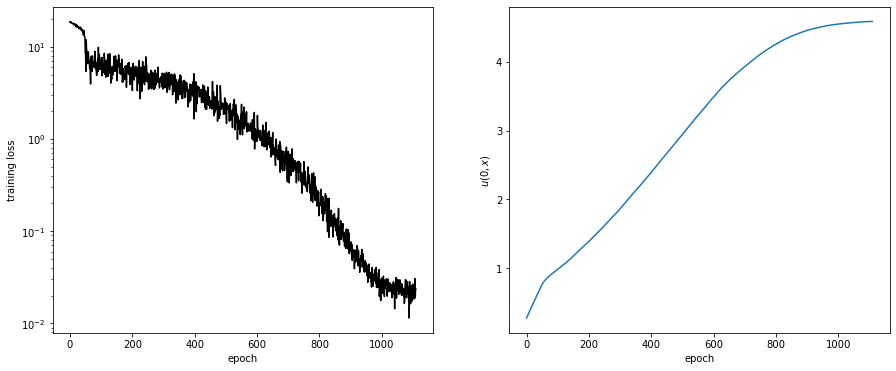

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
xrange = range(len(history))
ax[0].semilogy(xrange, [e[1] for e in history],'k-')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('training loss')
ax[1].plot(xrange, [e[2] for e in history])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('$u(0,x)$');

## Class implementation

The following code cell implements the Deep BSDE solver for the evaluation of the PDE solution in one point $(t_0,x)$ as one class, which is more handy for further experiments.
The final problem-specific solver is then derived through subclassing by defining methods for the reaction term $f$ and final data $g$.

**Note**: In order to construct a neural network approximation of the PDE solution on a domain of interest $\mathcal D$ at a fixed time $t = t_0$ instead of at a single point $x \in \mathbb R^d$ the following modifications are necessary:
- sample $x = X_0$ uniformly from $\mathcal D$  as in the [Feynman-Kac solver (GitHub)](https://github.com/janblechschmidt/PDEsByNNs/blob/main/Feynman-Kac_Solver.ipynb),
- replace the variables for $\tilde Y_0$ and $\tilde Z_0$ by appropriate neural networks which approximate the mappings $x \mapsto u(t_0, x)$ and $u \mapsto (\sigma^T \nabla u)(t_0, x)$.

In [ ]:
class DeepBSDE(tf.keras.Model):
    def __init__(self, t0=0.0,
                 t1=1.0,
                 dim=100,
                 time_steps=20,
                 sigma=np.sqrt(2),
                 learning_rate=1e-2,
                 num_hidden_layers=2,
                 num_neurons=200,
                 **kwargs):
        """Set up basic architecture of deep BSDE NN model."""
        
        super().__init__(**kwargs)
        
        self.t0 = t0
        self.t1 = t1
        self.N = time_steps
        self.dim = dim
        self.sigma = sigma
        self.x = 0.0*np.ones(self.dim)
        self.dt = (t1 - t0)/(self.N)
        self.sqrt_dt = np.sqrt(self.dt)
        
        self.t_space = np.linspace(self.t0, self.t1, self.N + 1)[:-1]
        
        # Set optimizer
        self.optimizer=tf.keras.optimizers.Adam(learning_rate,
                                                epsilon=1e-8)
        
        # Initialize value and gradient of u(t_0,X_{t_0}) by zeros
        #self.u0 = tf.Variable(np.zeros((1),dtype=DTYPE))
        #self.gradu0 = tf.Variable(np.zeros((1,self.dim),dtype=DTYPE))
        
        # Alternatively, initialize both randomly
        self.u0 = tf.Variable(np.random.uniform(.3, .5, size=(1)).astype(DTYPE))
        self.gradu0 = tf.Variable(np.random.uniform(-1e-1, 1e-1, size=(1, dim)).astype(DTYPE))
        
        # Create template of dense layer without bias and activation
        _dense = lambda dim: tf.keras.layers.Dense(
            units=dim,
            activation=None,
            use_bias=False)
        
        # Create template of batch normalization layer
        _bn = lambda : tf.keras.layers.BatchNormalization(
            momentum=.99,
            epsilon=1e-6,
            beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
            gamma_initializer=tf.random_uniform_initializer(0.1, 0.5))
        
        
        # Initialize a list of networks approximating the gradient of u(t, x) at t_i
        self.gradui = []
        
        # Loop over number of time steps
        for _ in range(self.N - 1):
            
            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())
            
            # Hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(num_hidden_layers):
                this_grad.add(_dense(num_neurons))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.ReLU())
                
            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.gradui.append(this_grad)
      
            
    def draw_X_and_dW(self, num_sample):
        """ Method to draw num_sample paths of X. """
        
        # Draw increments of Brownian motion
        dW = np.random.normal(loc=0.0, scale=self.sqrt_dt, size=(num_sample, self.dim, self.N)).astype(DTYPE)
        
        # Initialize and set array of paths
        X = np.zeros((num_sample, self.dim, self.N+1), dtype=DTYPE)
        
        X[:, :, 0] = np.ones((num_sample, self.dim)) * self.x
        
        for i in range(self.N):
            # This corresponds to the Euler-Maruyama Scheme
            X[:, :, i+1] = X[:, :, i] + self.sigma * dW[:, :, i]
            
        # Return simulated paths as well as increments of Brownian motion
        return X, dW
    
    @tf.function
    def call(self, inp, training=False):
        """
        Method to perform one forward sweep through the network
        given inputs: inp - (X, dW)
                      training - boolean variable indicating training
        """
        X, dW = inp
        num_sample = X.shape[0]
        
        
        e_num_sample = tf.ones(shape=[num_sample, 1], dtype=DTYPE)
        
        # Value approximation at t0
        y = e_num_sample * self.u0
        
        # Gradient approximation at t0
        z = e_num_sample * self.gradu0
        
        for i in range(self.N-1):
            
            t = self.t_space[i]
            
            # Optimal control is attained by gradient
            eta1 = - self.fun_f(t, X[:, :, i], y, z) * self.dt
            eta2 = tf.reduce_sum(z * dW[:, :, i], axis=1, keepdims=True)

            y = y + eta1 + eta2

            # New gradient approximation
            # The division by self.dim acts as a stabilizer
            z = self.gradui[i](X[:, :, i + 1], training) / self.dim

        # Final step
        eta1 = - self.fun_f(self.t_space[self.N-1], X[:, :, self.N-1], y, z) * self.dt
        eta2 = tf.reduce_sum(z * dW[:, :, self.N-1], axis=1, keepdims=True)

        y = y + eta1 + eta2

        return y
    
    def loss_fn(self, inputs, training=False):
        X, _ = inputs
        # Forward pass to compute value estimates
        y_pred = self.call(inputs, training)
        
        # Exact values at final time
        y = self.fun_g(X[:, :, -1])
        y_diff = y-y_pred
        loss = tf.reduce_mean(tf.square(y_diff))
        
        return loss
    
    @tf.function
    def train(self, inp):
        loss, grad = self.grad(inp, training=True)
        self.optimizer.apply_gradients(zip(grad, self.trainable_variables))
        return loss
    
    @tf.function
    def grad(self, inputs, training=False):
        with tf.GradientTape() as tape:
            loss = self.loss_fn(inputs, training)
        grad = tape.gradient(loss, self.trainable_variables)
        return loss, grad
    
    def fun_f(self, t, x, y, z):
        raise NotImplementedError
        
    def fun_g(self, t, x, y, z):
        raise NotImplementedError

### Example 1: Solution of the linear-quadratic Gaussian control problem
Next, we derive a class to solve the linear-quadratic Gaussian control problem (HJB equation)

$$
\begin{aligned}
u_t(t,x) + \Delta u(t,x) - \|\nabla u(t,x)\|^2 &= 0,\\
u(T,x) &= g(x).
\end{aligned}
$$

The class includes also a method `estimate_solution()` to approximate the exact solution by means of a Monte-Carlo estimation.
In can be shown (see [E, Han, Jenzten (2017), Lemma 4.2](https://arxiv.org/abs/1706.04702) ) that the solution of the PDE in a point $(0,x)$ is given by the expression

$$
u(0,x) = \log \left(
\mathbb{E} \left[
\exp(-g(x + \sigma W_T))
\right]
\right).
$$

In [ ]:
class HJBSolver(DeepBSDE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # 'Exact' solution at (0,x) has been determined with the method estimate_solution()
        self.y_star = 4.590147312917355
        
    # Running cost
    @tf.function
    def fun_f(self, t, x, y, z):
        return - tf.reduce_sum(tf.square(z), axis=1, keepdims=True) / (self.sigma**2)

    # Terminal/Final cost
    @tf.function
    def fun_g(self, x):
        return tf.math.log( (1+tf.reduce_sum(tf.square(x), axis=1, keepdims=True)) / 2)
    
    def estimate_solution(self, mc_iter=1e5, N_runs=200, replace=False):
        """This method can be used to estimate the solution at (0,x) by means of
        Monte-Carlo estimation."""
        N_total = 0
        total_mean = 0
        old_est = 0
        np.random.seed(0)
        for _ in range(int(N_runs)):
            W = np.random.normal(loc=0.0, scale=np.sqrt(model.t1-model.t0), size=(int(mc_iter), model.dim))
            X_T = model.x + model.sigma * W
            this_mean = np.mean(np.exp(-model.fun_g(X_T)))
    
            total_mean = (N_total * total_mean + mc_iter * this_mean) / (N_total + mc_iter)
            N_total+=mc_iter
            total_est = - np.log(total_mean)
            est_diff = np.abs(total_est-old_est)
            print('Current estimate: ', total_est, '\tDiff: ', est_diff)
            old_est = total_est
        if replace:
            self.y_star = total_est
        return total_est

In [ ]:
model=HJBSolver()
model.estimate_solution()

Design small experiment for testing.

In [ ]:
def experiment(model, num_epochs=2000):
    # Initialize header
    print('  Iter        Loss        y   L1_rel    L1_abs   |   Time  Stepsize')
    
    # Init timer and history list
    t0 = time()
    history=[]
    for i in range(num_epochs):
        
        inp = model.draw_X_and_dW(batch_size)
        loss = model.train(inp)

        # Get current Y_0 \approx u(0,x)
        y = model.u0.numpy()[0]

        currtime = time() - t0
        l1abs = np.abs(y - model.y_star)
        l1rel = l1abs / model.y_star

        hentry = (i, loss.numpy(), y, l1rel, l1abs, currtime, lr)
        history.append(hentry)
        if i%100 == 0:
            print('{:5d} {:12.4f} {:8.4f} {:8.4f}  {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))
    return history

Parameter settings for experiments carried out in the paper, Section 4.3.

In [ ]:
num_exp = 5
batch_size = 64
lr = 1e-2
dim = 100
History = []
prob_id = 4
if prob_id == 1:
    # Exp 1: Orig
    num_neurons = 110
    num_hidden_layers = 2
    num_time_steps = 20
    suffix = 'orig'
elif prob_id == 2:
    # Exp 2: 3 layers
    num_neurons = 200
    num_hidden_layers = 3
    num_time_steps = 30
    suffix = '3layers'
elif prob_id == 3:
    # Exp 3: 5 layers
    num_neurons = 300
    num_hidden_layers = 5
    num_time_steps = 50
    suffix = '5layers'
elif prob_id == 4:
    # Exp 4: simple model
    num_neurons = 110
    num_hidden_layers = 0
    num_time_steps = 1
    suffix = 'simple'

for j in range(num_exp):
    print('{:s}\nStart of run {:d}\n{:s}'.format(70*'-',j+1,70*'-'))

    # Experiment 1: Linear-quadratic Gaussian control - HJB equation
    model = HJBSolver(t1=1.,
                            time_steps=num_time_steps,
                            dim=dim,
                            learning_rate=lr,
                            num_neurons=num_neurons,
                            num_hidden_layers=num_hidden_layers)
    history = experiment(model, num_epochs=20000)
    
    History.append(history)

Write statistics to `csv` file.

In [ ]:
X=np.stack(History)
epochs = X[0,:,0].astype(int)

# Derive statistics for table
Loss_mean = np.mean(X[:,:,1], axis=0)
Loss_std = np.std(X[:,:,1], axis=0)
y_mean = np.mean(X[:,:,2], axis=0)
y_std = np.std(X[:,:,2], axis=0)
L1rel_mean = np.mean(X[:,:,3], axis=0)
L1rel_std = np.std(X[:,:,3], axis=0)
L1abs_mean = np.mean(X[:,:,4], axis=0)
L1abs_std = np.std(X[:,:,4], axis=0)
Time_mean = np.mean(X[:,:,5], axis=0)
Time_std = np.std(X[:,:,5], axis=0)

# Write table
SAVE_CSV = True
if SAVE_CSV:
    import csv
    with open('hjb_dim_{:03d}_{:s}.csv'.format(dim, suffix),'w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['Iter', 'LossMean', 'LossStd', 'yMean', 'yStd', 'L1relMean', 'L1relStd', 'L1absMean', 'L1absStd', 'TimeMean','TimeStd'])
        for i in epochs:
            csv_out.writerow((i, Loss_mean[i], Loss_std[i],
                              y_mean[i], y_std[i], L1rel_mean[i], L1rel_std[i],
                              L1abs_mean[i], L1abs_std[i], Time_mean[i], Time_std[i]))

Finally, we may plot some loss curves and errors.

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,6))
color = 'tab:blue'
ax[0].semilogy(epochs, Loss_mean, color=color)
ax[0].fill_between(epochs, Loss_mean-Loss_std, Loss_mean+Loss_std, alpha=0.2)
ax[0].set_xlabel('$n_{epoch}$')
ax[0].set_ylabel('Loss')
ax[0].set_title('Mean loss')

ax[1].plot(epochs, y_mean, color=color)
ax[1].fill_between(epochs, y_mean-y_std, y_mean+y_std, alpha=0.2)
ax[1].set_xlabel('$n_{epoch}$')
ax[1].set_ylabel('$y=u(0,x)$')
ax[1].set_ylim([4.55,4.65])
ax[1].set_title('Mean $u(0,x)$')


ax[2].semilogy(epochs, L1rel_mean, color=color)
ax[2].fill_between(epochs, L1rel_mean-L1rel_std, L1rel_mean+L1rel_std, alpha=0.2,color=color)
ax[2].set_xlabel('$n_{epoch}$')
ax[2].set_ylabel('$L1_rel$')
ax[2].set_ylim([1e-5,5*1e-1])
ax[2].set_title('Mean rel. error');

### Example 2: Allen-Cahn equation
Next, we derive a solver for the $d$-dimensional Allen-Cahn equation with "double-well potential" which is characterized by the semilinear PDE

$$
u_t(t,x) + \Delta u(t,x) + u(t,x) - u^3(t,x) = 0.
$$

See Section 4.4 in the paper for further details.

In [ ]:
class AllenCahnSolver(DeepBSDE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.y_star = .052802

        
    # Running cost
    @tf.function
    def fun_f(self, t, x, y, z):
        return y - tf.pow(y,3)

    # Terminal/Final cost
    @tf.function
    def fun_g(self, x):
        return 1./(2. + 2./5 * tf.reduce_sum(tf.square(x), axis=1, keepdims=True))

Parameter settings for experiments carried out in the paper, Section 4.4.

In [ ]:
num_exp = 5
batch_size = 64
lr = 5e-4
dim = 100
History = []
prob_id = 4
if prob_id == 1:
    # Exp 1: Orig
    num_neurons = 110
    num_hidden_layers = 2
    num_time_steps = 20
    suffix = 'orig'
elif prob_id == 2:
    # Exp 2: 3 layers
    num_neurons = 200
    num_hidden_layers = 3
    num_time_steps = 30
    suffix = '3layers'
elif prob_id == 3:
    # Exp 3: 5 layers
    num_neurons = 300
    num_hidden_layers = 5
    num_time_steps = 50
    suffix = '5layers'
elif prob_id == 4:
    # Exp 4: simple model
    num_neurons = 110
    num_hidden_layers = 0
    num_time_steps = 1
    suffix = 'simple'
    

for j in range(num_exp):
    print('{:s}\nStart of run {:d}\n{:s}'.format(70*'-',j+1,70*'-'))

    # Experiment 2: Allen-Cahn equation
    model = AllenCahnSolver(t1=3./10,
                            time_steps=num_time_steps,
                            dim=dim,
                            learning_rate=lr,
                            num_neurons=num_neurons,
                            num_hidden_layers=num_hidden_layers)
    
    history = experiment(model, num_epochs=4000)
    History.append(history)    

Write statistics to `csv` file.

In [ ]:
X=np.stack(History)
epochs = X[0,:,0].astype(int)

# Derive statistics for table
Loss_mean = np.mean(X[:,:,1], axis=0)
Loss_std = np.std(X[:,:,1], axis=0)
y_mean = np.mean(X[:,:,2], axis=0)
y_std = np.std(X[:,:,2], axis=0)
L1rel_mean = np.mean(X[:,:,3], axis=0)
L1rel_std = np.std(X[:,:,3], axis=0)
L1abs_mean = np.mean(X[:,:,4], axis=0)
L1abs_std = np.std(X[:,:,4], axis=0)
Time_mean = np.mean(X[:,:,5], axis=0)
Time_std = np.std(X[:,:,5], axis=0)

# Write table
SAVE_CSV = True
if SAVE_CSV:
    import csv
    with open('allen-cahn_dim_{:03d}_{:s}.csv'.format(dim, suffix),'w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['Iter', 'LossMean', 'LossStd', 'yMean', 'yStd', 'L1relMean', 'L1relStd', 'L1absMean', 'L1absStd', 'TimeMean','TimeStd'])
        for i in epochs:
            csv_out.writerow((i, Loss_mean[i], Loss_std[i],
                              y_mean[i], y_std[i], L1rel_mean[i], L1rel_std[i],
                              L1abs_mean[i], L1abs_std[i], Time_mean[i], Time_std[i]))

Finally, we may plot some loss curves and errors.

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,6))
color = 'tab:blue'
ax[0].semilogy(epochs, Loss_mean, color=color)
ax[0].fill_between(epochs, Loss_mean-Loss_std, Loss_mean+Loss_std, alpha=0.2)
ax[0].set_xlabel('$n_{epoch}$')
ax[0].set_ylabel('Loss')
ax[0].set_title('Mean loss')

ax[1].plot(epochs, y_mean, color=color)
ax[1].fill_between(epochs, y_mean-y_std, y_mean+y_std, alpha=0.2)
ax[1].set_xlabel('$n_{epoch}$')
ax[1].set_ylabel('$y=u(0,x)$')
#ax[1].set_ylim([0.053,0.09])
ax[1].set_title('Mean $u(0,x)$')


ax[2].semilogy(epochs, L1rel_mean, color=color)
ax[2].fill_between(epochs, L1rel_mean-L1rel_std, L1rel_mean+L1rel_std, alpha=0.2,color=color)
ax[2].set_xlabel('$n_{epoch}$')
ax[2].set_ylabel('$L1_rel$')
#ax[2].set_ylim([1e-3,1e-0])
ax[2].set_title('Mean rel. error');

### Example 3: Burgers equation
Finally, we construct a solver for the following $d$-dimensional Burgers equation (with coefficients $\mu \equiv 0$ and $\sigma \equiv d \, I_{d \times d}$)

$$
u_t(t,x) + \frac{d^2}{2} \Delta u(t,x) =
- \Big(u(t,x) - \frac{2+d}{2\,d}\Big)
\Big( d \sum_{i=1}^d \partial_{x_i} u (t,x) \Big)
$$

with final data

$$
u(1,x) = 1 - \Big(
1+\exp \big( 1 + \frac{1}{d} \sum_{i=1}^d x_i \big)
    \Big)^{-1}
$$

and explicitly known solution

$$
u(t,x) = 1 - \Big(
1+\exp \big( t + \frac{1}{d} \sum_{i=1}^d x_i \big)
    \Big)^{-1},
$$

see also Section 4.5 and Lemma 4.3 in [E, Han, Jentzen (2017)](https://arxiv.org/abs/1706.04702).

In [ ]:
class BurgersSolver(DeepBSDE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.sigma = self.dim
        
        z = tf.math.exp( self.t0 + 1./self.dim*tf.reduce_sum(self.x) ).numpy()
        self.y_star = 1 - 1./(1.+z) 
        
    # Running cost
    @tf.function
    def fun_f(self, t, x, y, z):
        return (y - (2+self.dim)/(2*self.dim)) * tf.reduce_sum(z, axis=1, keepdims=True)

    # Terminal/Final cost
    @tf.function
    def fun_g(self, x):
        z = tf.math.exp( self.t1 + 1./self.dim*tf.reduce_sum(x, axis=1, keepdims=True) )
        return 1 - 1./( 1. + z)

In [ ]:
# Experiment 3: Burgers equation
num_epochs=60000
batch_size=64
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([30000,50000],[1e-2,1e-3,1e-4])
model = BurgersSolver(t1=1.,
                      time_steps=80,
                      dim=20,
                      num_neurons=30,
                      learning_rate=lr)

# Initialize header
print('  Iter        Loss        y   L1_rel    L1_abs   |   Time  Stepsize')

# Init timer and history list
t0 = time()
history=[]
for i in range(num_epochs):
    
    inp = model.draw_X_and_dW(batch_size)
    loss = model.train(inp)

    # Get current Y_0 \approx u(0,x)
    y = model.u0.numpy()[0]

    currtime = time() - t0
    l1abs = np.abs(y - model.y_star)
    l1rel = l1abs / model.y_star

    hentry = (i, loss.numpy(), y, l1rel, l1abs, currtime, lr(i))
    history.append(hentry)
    if i%100 == 0:
        print('{:5d} {:12.4f} {:8.4f} {:8.4f}  {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))


Plot statistics.

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,6))
color = 'tab:blue'
X = np.stack(history)
epochs = X[:,0]
loss = X[:,1]
ax[0].semilogy(epochs, loss, color=color)
ax[0].set_xlabel('$n_{epoch}$')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')

yval = X[:,2]
ax[1].plot(epochs, yval, color=color)
ax[1].set_xlabel('$n_{epoch}$')
ax[1].set_ylabel('$y=u(0,x)$')
ax[1].set_title('Value $u(0,x)$')

l1rel = X[:,3]
ax[2].semilogy(epochs, l1rel, color=color)
ax[2].set_xlabel('$n_{epoch}$')
ax[2].set_ylabel('$L1_rel$')
#ax[2].set_ylim([1e-5,5*1e-1])
ax[2].set_title('Rel. error');